In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import matplotlib
from fourpop import fourpop
import scipy.io as io

# Four Population Model with VIP-SOM connections

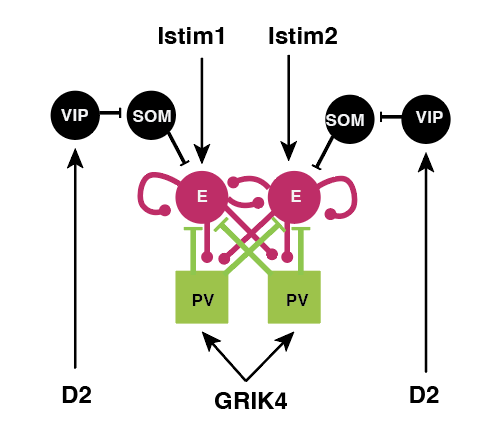  

Following the model in Roach et al.2023 for a Four Population Model first to create a stable 4 population dyamical model.

Then added interneuron connections in the form of VIP and SOM.  
$ r_{VIP} = 5 * \mathrm{D2} $  
$ r_{SOM} = \mathrm{max}(0, \beta_{SOM} (J_{VIP-SOM}*r_{VIP} - I_{SOM,rh} + I_bg{SOM}))$


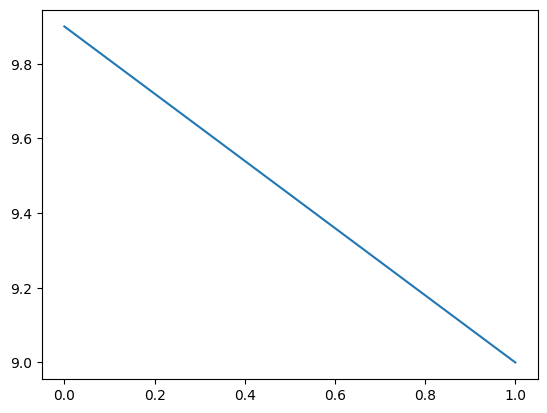

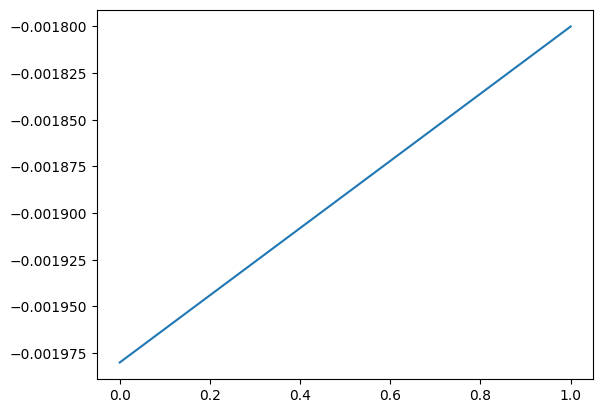

In [112]:
JVIP = -0.002
rVIP = 5.
I_SOM_rh = 0.04
bSOM = 90.

JSOM = -0.0002

D2 = np.linspace(0, 1)
y = bSOM*(JVIP*rVIP*D2 - I_SOM_rh + 0.150)
plt.plot(D2, y)
plt.subplots()
plt.plot(D2, JSOM*y)

In [183]:
class fourpop():
    def __init__(self, GRIK4: float, D2: iter,  custom_args:dict = None, p: dict = None):
        # Parameters
        if p != None:
            # print("Using custom parameters")
            self.p = p
        else:
            # print("No parameter dict given. Creating model with default parameters")
            default_params = self.default_params()
            self.p = default_params

        if custom_args:
            self.p.update(custom_args)
            
        # set important attr from params
        self.NT = int(self.p['T']/self.p['dt'])
        self.dt = self.p['dt']
        self.timerange = np.linspace(0, self.p['T'], self.NT)
        self.GRIK4 = GRIK4
        self.D2 = D2

        # Create the D2 and GRIK4 arrays
        self.I_GRIK = np.array([0, 0, self.GRIK4*self.p['JGRIKPV'], self.GRIK4*self.p['JGRIKPV']])
                
        # create background current array (since this comes up a lot)
        self.I0 = np.array([self.p['I0E'], self.p['I0E'], self.p['I0I'], self.p['I0I']])

        # create adjacency matrix
        self.A = self.adjacency()
    
    def default_params(self):
        p = {}
        # ---------- PARAMS ------------
        # firing rate 
        p['aE'] = 310
        p['bE'] = 125
        p['dE'] = 0.16

        p['aI'] = 615 
        p['bI'] = 177 
        p['dI'] = 0.087

        p['T'] = 7.      # [s]
        p['dt'] = 0.002  # [s]
        p['Tstim'] = 2.  # [s]
        p['Tdur']  = 2. # [s]

        p['sigma'] = 0.2       # nA
        p['tauN'] = 0.100      # slow excitatory synaptic time constant
        p['tauG'] = 0.005       # [s] inhibitory synaptic time constant
        p['tauA'] = 0.002        # [s]

        p['Jampa_ext'] = 5.2e-4 # nA
        p['mu'] = 40
        p['coh'] = 0

        p['betaSOM'] = 90
        p['I_SOM_rh'] = 0.04    # nA rheobase SOM
        p['I_SOM_bg'] = 0.15    # baseline SOM input current

        p['JVIP'] = -0.001    # VIP to SOM
        p['JSOM'] = -0.0002  # SOM to Exc
        p['JGRIKPV']  = 0.001

        p['gamma'] = 0.641   # firing rate to NMDA activation multiplier

        p['JNE'] = 0.42345756
        p['JNI'] = 0.57431432
        p['JGE'] = -0.46992407
        p['JGI'] = -0.64211589

        p['I0E'] = 0.77071143
        p['I0I'] = 1.02669666

        p['See'] = 0.32
        p['Sei'] = 0.25
        p['Sie'] = 0
        p['Sii'] = 0

        p['Ns'] = 2
        p['w_e'] = 1
        p['w_i'] = 1

        return p
    
    def adjacency(self):
        # calculate and return the input matrix
        p = self.p
        Ns = p['Ns']

        what_ee = Ns*p['w_e']/(Ns + p['See']*(2 - Ns)) 
        what_ei = Ns*p['w_e']/(Ns + p['Sei']*(2 - Ns)) 
        what_ie = Ns*p['w_i']/(Ns + p['Sie']*(2 - Ns)) 
        what_ii = Ns*p['w_i']/(Ns + p['Sii']*(2 - Ns)) 

        wpee = what_ee + p['See']*what_ee 
        wmee = what_ee - p['See']*what_ee 
        wpei = what_ei + p['Sei']*what_ei 
        wmei = what_ei - p['Sei']*what_ei 
        wpie = what_ie + p['Sie']*what_ie 
        wmie = what_ie - p['Sie']*what_ie 
        wpii = what_ii + p['Sii']*what_ii 
        wmii = what_ii - p['Sii']*what_ii 

        A = np.zeros([4,4]) 

        A[0,:] = [wpee*p['JNE'],wmee*p['JNE'],wpie*p['JGE'],wmie*p['JGE']]  #inputs to E1
        A[1,:] = [wmee*p['JNE'],wpee*p['JNE'],wmie*p['JGE'],wpie*p['JGE']]  #inputs to E2
        A[2,:] = [wpei*p['JNI'],wmei*p['JNI'],wpii*p['JGI'],wmii*p['JGI']]  #inputs to I1
        A[3,:] = [wmei*p['JNI'],wpei*p['JNI'],wmii*p['JGI'],wpii*p['JGI']]  #inputs to I2

        return A
    
    def run(self):
        def F(I, a, b, d):
            return (a*I - b)/(1 - np.exp(-d*(a*I - b)))
        
        NT = self.NT
        dt = self.dt
        A = self.A

        gwn = np.random.randn(4, NT)
        
        Ieta = np.zeros((4, NT+1))

        S = np.zeros((4, NT+1))
        S[0:2, 0] = (np.random.rand(2)*0.05 + 0.0)
        S[2:4, 0] = (np.random.rand(2)*0.05 + 0.275)
        
        r = np.zeros((4, NT))

        # firing rates for interneurons involved in disinhibition
        # 0 VIP1; 1 VIP2; 2 SOM1; 3 SOM2;
        r_vs = np.zeros((4, NT))
        
        for t, time in enumerate(self.timerange): #Loop through time for a trial

            #---- Stimulus------------------------------------------------------
            Istim1  = ((self.p['Tstim']/dt < t) & (t<(self.p['Tstim']+self.p['Tdur'])/dt)) * (self.p['Jampa_ext']*self.p['mu']*(1+self.p['coh']/100)) # To population 1
            Istim2 = ((self.p['Tstim']/dt < t) & (t<(self.p['Tstim']+self.p['Tdur'])/dt)) * (self.p['Jampa_ext']*self.p['mu']*(1-self.p['coh']/100)) # To population 2
            Istim = np.array([Istim1, Istim2, 0., 0.])

            # Interneuron output
            r_vs[0:2,t] = 5 * self.D2
            rate_SOM = self.p['betaSOM']*(self.p['JVIP']*r_vs[0:2, t] - self.p['I_SOM_rh'] + self.p['I_SOM_bg'])
            r_vs[2:4,t] = np.where(rate_SOM<0, 0, rate_SOM)
            I_SOM = np.zeros(4)
            I_SOM[0:2] = self.p['JSOM'] * r_vs[2:4, t]

            # Total synaptic input
            s_array = S[:,t]
            I = np.matmul(A, s_array) + self.I0 + Istim + self.I_GRIK + I_SOM + Ieta[:,t]

            # Transfer function to get firing rate
            r[0:2, t] = F(I[0:2], self.p['aE'], self.p['bE'], self.p['dE'])
            r[2:4, t] = F(I[2:4], self.p['aI'], self.p['bI'], self.p['dI'])
        
            #---- Dynamical equations -------------------------------------------

            # Mean synaptic dynamics updating
            S[0:2, t+1] = S[0:2,t] + dt*(-S[0:2,t]/self.p['tauN'] + (1-S[0:2,t])*self.p['gamma']*r[0:2,t])
            S[2:4,t+1] = S[2:4,t] + dt*(-S[2:4,t]/self.p['tauG'] + r[2:4,t])

            # Ornstein-Uhlenbeck generation of noise in pop1 and 2
            Ieta[:, t+1] = Ieta[:,t] + (dt/self.p['tauA']) * (-Ieta[:,t]) + np.sqrt(self.p['tauA'])*self.p['sigma']*gwn[:,t]

        return {'r': r, 'S': S, 'rvs': r_vs,
                't':self.timerange}
    
    def dsdt(self, s, ifstim=True):
        I_stim = np.zeros([4])
        x      = np.zeros([4])
        r_vs    = np.zeros([4])
        H      = np.zeros([4])
        dS     = np.zeros([4])

        # stim
        if ifstim:
            I_stim[0] = self.p['Jampa_ext'] * self.p['mu'] * (1+self.p['coh']/100) 
            I_stim[1] = self.p['Jampa_ext'] * self.p['mu'] * (1-self.p['coh']/100)

        # Interneuron output
        r_vs[0:2] = 5 * self.D2
        rate_SOM = self.p['betaSOM']*(self.p['JVIP']*r_vs[0:2] - self.p['I_SOM_rh'] + self.p['I_SOM_bg'])
        r_vs[2:4] = np.where(rate_SOM<0, 0, rate_SOM)
        I_SOM = np.zeros(4)
        I_SOM[0:2] = self.p['JSOM'] * r_vs[2:4]

        # input
        x[:] = np.matmul(self.A,s) + self.I0 + I_stim + self.I_GRIK + I_SOM

        # freq
        H[0:2]  = (self.p['aE']*x[0:2] - self.p['bE'])/(1 - np.exp(-self.p['dE']*(self.p['aE']*x[0:2] - self.p['bE']))) 
        H[2:4]  = (self.p['aI']*x[2:4] - self.p['bI'])/(1 - np.exp(-self.p['dI']*(self.p['aI']*x[2:4] - self.p['bI']))) 

        # s
        dS[0:2] = -1*(self.p['tauN']**-1)*s[0:2] + (1-s[0:2])*self.p['gamma']*H[0:2]
        dS[2:4] = -1*(self.p['tauG']**-1)*s[2:4] + H[2:4]

        return dS
    
    def fourvar_jac(self, S, ifstim=True):
        # jacobian
        aE = self.p['aE']
        bE = self.p['bE']
        dE = self.p['dE']
        aI = self.p['aI']
        bI = self.p['bI']
        dI = self.p['dI']

        taus = np.array([self.p['tauN'], self.p['tauN'], self.p['tauG'], self.p['tauG']])

        I_stim = np.zeros([4])
        H      = np.zeros([4])
        r_vs   = np.zeros([4])

        dHds   = np.zeros([4,4])
        dsds   = np.zeros([4,4])

        # Interneuron output
        r_vs[0:2] = 5 * self.D2
        rate_SOM = self.p['betaSOM']*(self.p['JVIP']*r_vs[0:2] - self.p['I_SOM_rh'] + self.p['I_SOM_bg'])
        r_vs[2:4] = np.where(rate_SOM<0, 0, rate_SOM)
        I_SOM = np.zeros(4)
        I_SOM[0:2] = self.p['JSOM'] * r_vs[2:4]

        if ifstim:
            I_stim[0] = self.p['Jampa_ext'] * self.p['mu'] * (1+self.p['coh']/100) 
            I_stim[1] = self.p['Jampa_ext'] * self.p['mu'] * (1-self.p['coh']/100)

        dxds = self.A

        x = np.matmul(self.A,S) + self.I0 + I_stim + self.I_GRIK + I_SOM
        H[0:2] = (aE*x[0:2] - bE)/(1 - np.exp(-dE*(aE*x[0:2] - bE))) 
        H[2:4] = (aI*x[2:4] - bI)/(1 - np.exp(-dI*(aI*x[2:4] - bI)))

        for i in range(4):
            dHds[0,i] = (aE*dxds[0,i]*(1 - np.exp(-dE*(aE*x[0]-bE))) - aE*dE*np.exp(-dE*(aE*x[0]-bE))*dxds[0,i]*(aE*x[0]-bE))/ ((1 - np.exp(-dE*(aE*x[0] - bE))))**2
            dHds[1,i] = (aE*dxds[1,i]*(1 - np.exp(-dE*(aE*x[1]-bE))) - aE*dE*np.exp(-dE*(aE*x[1]-bE))*dxds[1,i]*(aE*x[1]-bE))/ ((1 - np.exp(-dE*(aE*x[1] - bE))))**2
            dHds[2,i] = (aI*dxds[2,i]*(1 - np.exp(-dI*(aI*x[2]-bI))) - aI*dI*np.exp(-dI*(aI*x[2]-bI))*dxds[2,i]*(aI*x[2]-bI))/ ((1 - np.exp(-dI*(aI*x[2] - bI))))**2
            dHds[3,i] = (aI*dxds[3,i]*(1 - np.exp(-dI*(aI*x[3]-bI))) - aI*dI*np.exp(-dI*(aI*x[3]-bI))*dxds[3,i]*(aI*x[3]-bI))/ ((1 - np.exp(-dI*(aI*x[3] - bI))))**2

        dsds[0,0] = (-1/taus[0]) + self.p['gamma']*(-H[0] + dHds[0,0]*(1-S[0]))
        dsds[1,1] = (-1/taus[1]) + self.p['gamma']*(-H[1] + dHds[1,1]*(1-S[1]))
        dsds[2,2] = (-1/taus[2]) + dHds[2,2]
        dsds[3,3] = (-1/taus[3]) + dHds[3,3]

        for i in [0,1]:
            for j in range(4):
                if i != j:
                    dsds[i,j] = self.p['gamma']*(1-S[i])*dHds[i,j]
        for i in [2,3]:
            for j in range(4):
                if i != j:
                    dsds[i,j] = dHds[i,j]
        return dsds

    def get_fixed_points(self, ifstim):
        s = np.arange(0,1,0.1) # trial s values
        
        pts = []
        ddS  = []
        tol  = 1e-6     # tolerance
        stol = 1e-6

        for i in range(len(s)):
            for j in range(len(s)):
                # solve for solutions where dsdt = 0
                # Requires the corresponding jacobian.
                
                sol = optimize.fsolve(lambda s, ifstim: self.dsdt(s, ifstim), np.array([s[i],0.5,0.5,s[j]]), args=(ifstim), fprime=lambda s, ifstim: self.fourvar_jac(s, ifstim)) # returns the roots
                sol_ds = np.sqrt(np.sum(self.dsdt(sol, ifstim)**2)) # returns the magnitude of all the roots(?)

                if sol_ds < tol:
                    if (len(pts)>0):
                        if (np.any(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)):
                            for q,w in enumerate(np.where(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)[0]):
                                if sol_ds < ddS[w]:
                                    pts[w] = sol 
                                    ddS[w] = sol_ds
                        else:
                            pts.append(sol)
                            ddS.append(sol_ds)
                    else:
                        pts.append(sol)
                        ddS.append(sol_ds)

                sol = optimize.fsolve(lambda s, ifstim: self.dsdt(s, ifstim), np.array([0.5,s[i],s[j],0.5]), args=(ifstim), fprime=lambda s, ifstim: self.fourvar_jac(s, ifstim))
                sol_ds = np.sqrt(np.sum(self.dsdt(sol, ifstim)**2))
                
                if sol_ds < tol:
                    if (len(pts)>0):
                        if (np.any(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)):
                            for q,w in enumerate(np.where(np.sqrt(np.sum((pts-sol)**2,axis=1))<stol)[0]):
                                if sol_ds < ddS[w]:
                                    pts[w] = sol 
                                    ddS[w] = sol_ds
                        else:
                            pts.append(sol)
                            ddS.append(sol_ds)
                    else:
                        pts.append(sol)
                        ddS.append(sol_ds)
        pts   = np.array(pts)
        fps   = pts[np.isfinite(pts).all(axis=1),:]
        fps   = fps[np.argsort(fps[:,0]),:]
        stab  = np.zeros([fps.shape[0]])
        evals = [] 
        for i in range(fps.shape[0]):
            jac = self.fourvar_jac(fps[i], ifstim)
            if np.isfinite(jac).all():
                egs = np.linalg.eig(jac)
                evals.append(egs[0])
                if (egs[0]<0).all():
                    stab[i] = 1
            else:
                stab[i] = np.nan
                evals.append(np.array([np.nan]))
                
        return {'points':fps,'stable':stab,'eiganvalues':evals, 'dS':ddS}  



### GRIK4 and D2 Thalamic Control

Using a four population model (two choice-selective excitatory populations and two inhibitory populations), how does decision making improve?
D2 neurons
Aim I. Test the hypothesis that the MD D2+ system is a locus for uncertainty estimates and task
prediction errors.
hypothesize that MD D2+ neurons respond to sparse sensory inputs from prefrontal afferents
and to negative reinforcement from subcortical afferents.

Aim II. Test the hypothesis that MD D2+ neurons encode latent rule uncertainty and task prediction errors
in a hierarchical decision task.
(cue vs rule uncertaintly).

We hypothesize that
these pathways are relevant for uncertainty susceptibility in schizophrenia, because each appears to respond to a
specific form of sensory uncertainty and to regulate a separate aspect of prefrontal switching associated with
latent uncertainty.

**The MD thalamus flexibly regulates local and inter-areal prefrontal processingon the basis of combining cortically-derived uncertainty estimates with subcortical prediction errors.**

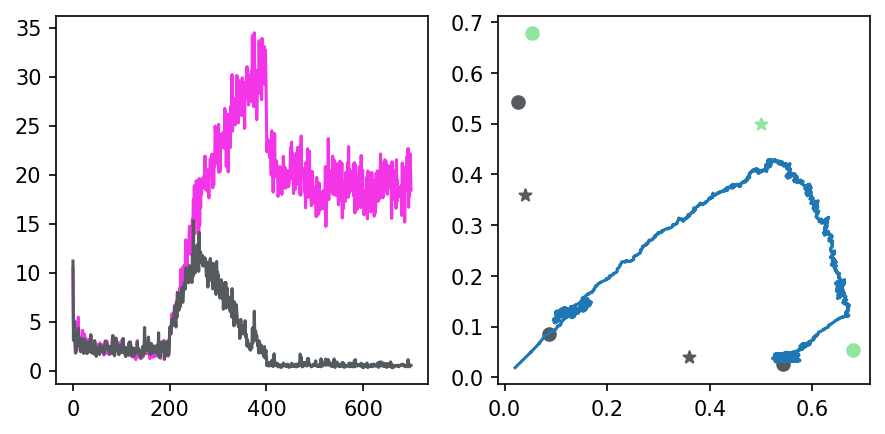

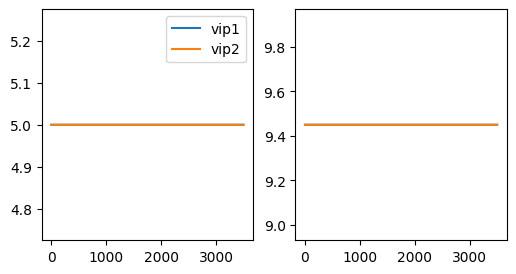

In [3]:
# Test Run with Phase Space Trajectory
run1 = fourpop(GRIK4=0.1, D2=np.array([1, 1]), custom_args={'JSOM':0}) # This will use default parameters
dat1 = run1.run()

# plot fixed points and trajectory

def plot_fixed_points(model):
    fig, axs = plt.subplots(1,2, figsize = (6,3), dpi=150)

    dat1 = model.run()
    axs[0].plot(np.mean(dat1['r'][0].reshape(-1, 5), axis=1), color = '#f434e7')
    axs[0].plot(np.mean(dat1['r'][1].reshape(-1,5), axis=1), color = '#545a5e')

    fp_u = model.get_fixed_points(ifstim=False)
    fp_s = model.get_fixed_points(ifstim=True)

    for j, point in enumerate(fp_u['points']):
        if fp_u['stable'][j] == 1:
            axs[1].scatter(point[0], point[1],c='#545a5e')
        else:
            axs[1].scatter(point[0], point[1], marker = '*',c='#545a5e')
    for j, point in enumerate(fp_s['points']):
        if fp_s['stable'][j] == 1:
            axs[1].scatter(point[0], point[1],c='#92e59e')
        else:
            axs[1].scatter(point[0], point[1], marker = '*',c='#92e59e')
    # ax = axs[1]
    # ax.set(xlabel="E1", ylabel='E2')
    # ax.scatter(fp_u['points'].T[0], fp_u['points'].T[1], c='#545a5e', label = 'No Stim')
    # ax.scatter(fp_s[0], fp_s[1], c='#92e59e', label = 'With stim')
    # ax.legend()
    axs[1].plot(dat1['S'][0], dat1['S'][1])
    plt.tight_layout()

    fig, axs = plt.subplots(1,2, figsize=(6,3))
    axs[0].plot(dat1['rvs'][0], label='vip1')
    axs[0].plot(dat1['rvs'][1], label='vip2')
    axs[0].legend()
    axs[1].plot(dat1['rvs'][2], label='som1')
    axs[1].plot(dat1['rvs'][3], label='som2')

plot_fixed_points(run1)

# fig, axs = plt.subplots(1,2, figsize=(6,3))
# axs[0].plot(dat1['rvs'][0], label='vip1')
# axs[0].plot(dat1['rvs'][1], label='vip2')
# axs[0].legend()
# axs[1].plot(dat1['rvs'][2], label='som1')
# axs[1].plot(dat1['rvs'][3], label='som2')


# Increasing MD-D2 stimulation of VIP interneurons (disinhibition)



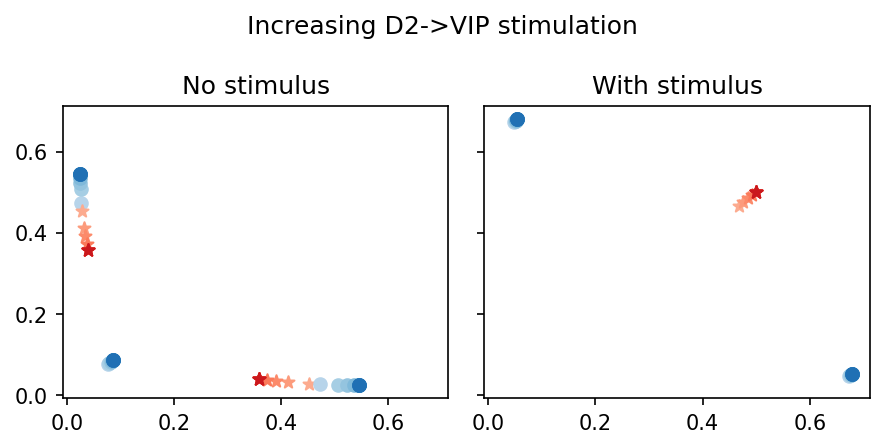

In [188]:
# Plot what happens to attractor space

D2_array = np.linspace(0,50,10)
cmap = [matplotlib.cm.get_cmap('Blues')(i) for i in np.linspace(0.3,1,15)]
cmap_r = [matplotlib.cm.get_cmap('Reds')(i) for i in np.linspace(0.3,1,15)]
fig, axs = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True, dpi=150)
axs[0].set_title('No stimulus')
axs[1].set_title('With stimulus')

for i, D2 in enumerate(D2_array):
    sim = fourpop(GRIK4=0., D2=D2)

    fp_u = sim.get_fixed_points(ifstim=False)
    fp_s = sim.get_fixed_points(ifstim=True)

    for j, point in enumerate(fp_u['points']):
        if fp_u['stable'][j] == 1:
            axs[0].scatter(fp_u['points'][j,0], fp_u['points'][j,1],c=[[cmap[i]]])
        else:
            axs[0].scatter(fp_u['points'][j,0], fp_u['points'][j,1], marker = '*',c=[[cmap_r[i]]])
    for j, point in enumerate(fp_s['points']):
        if fp_s['stable'][j] == 1:
            axs[1].scatter(fp_s['points'][j,0], fp_s['points'][j,1],c=[[cmap[i]]])
        else:
            axs[1].scatter(fp_s['points'][j,0], fp_s['points'][j,1], marker = '*',c=[[cmap_r[i]]])
fig.suptitle("Increasing D2->VIP stimulation")
fig.tight_layout()

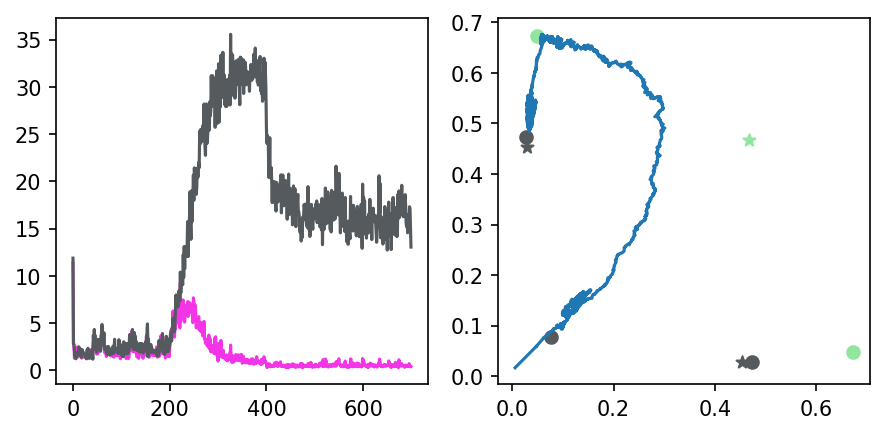

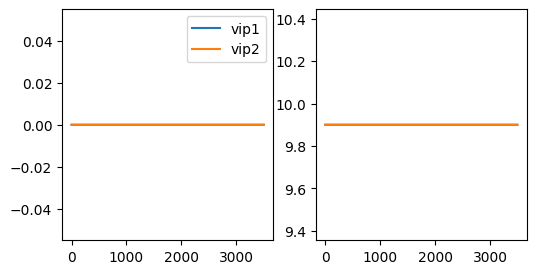

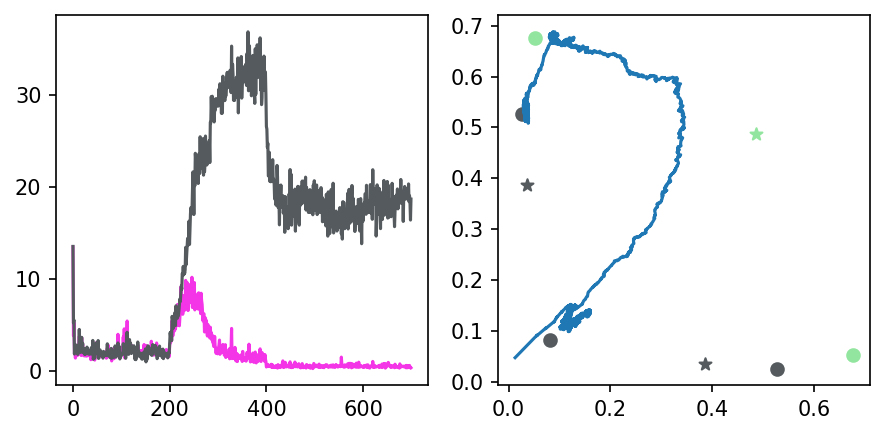

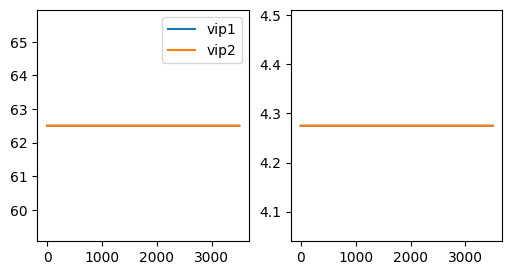

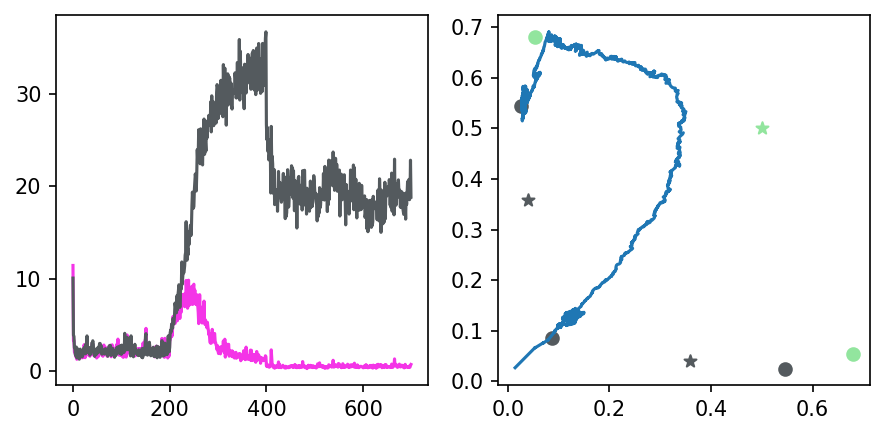

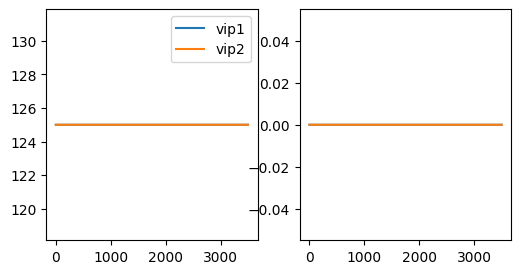

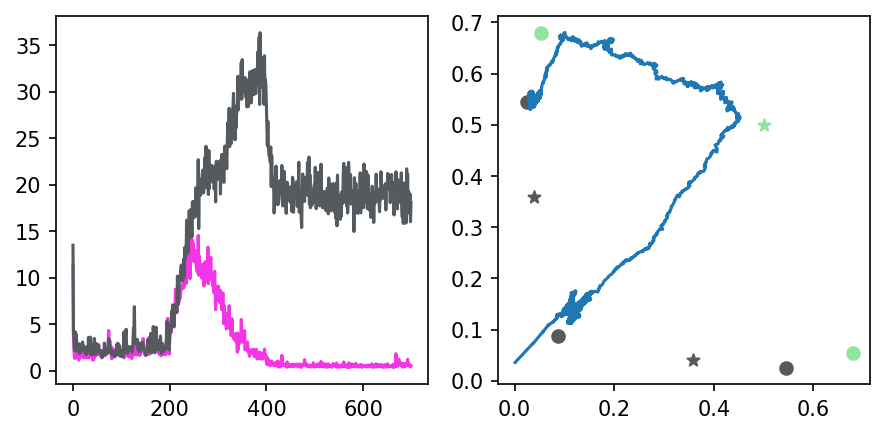

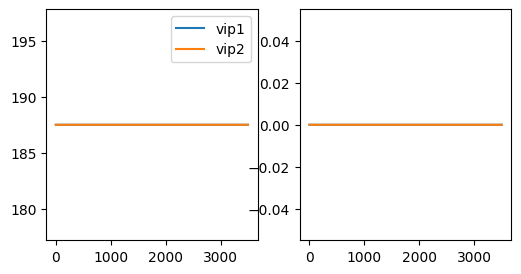

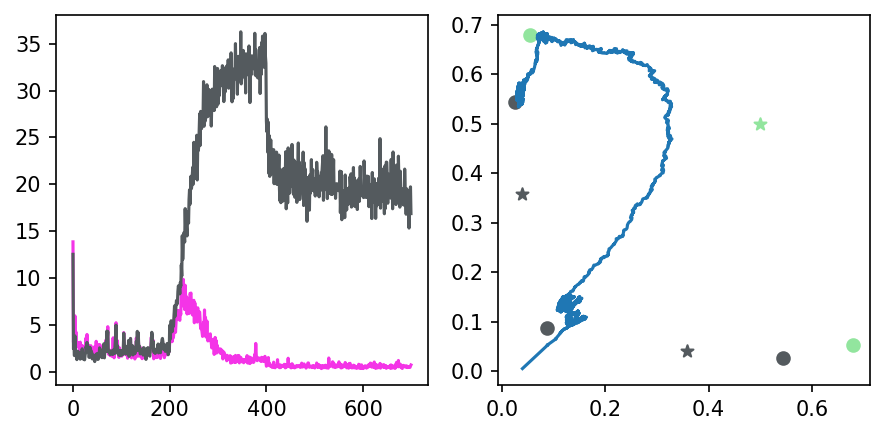

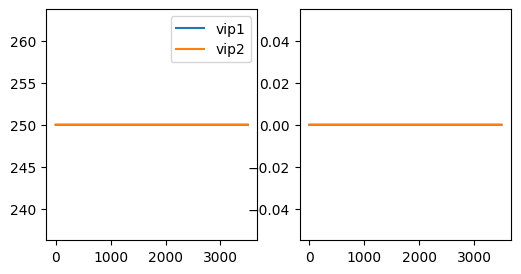

In [186]:
D2_array = np.linspace(0,50,5)
for i, D2 in enumerate(D2_array):
    sim = fourpop(GRIK4=0., D2 = D2)
    plot_fixed_points(sim)

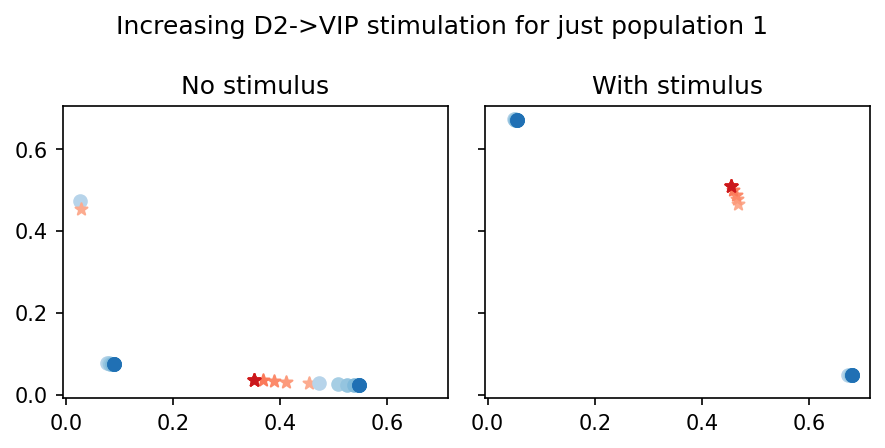

In [189]:
# Only increasing D2 for the population 1


D2_array = np.linspace(0,50,10)
cmap = [matplotlib.cm.get_cmap('Blues')(i) for i in np.linspace(0.3,1,15)]
cmap_r = [matplotlib.cm.get_cmap('Reds')(i) for i in np.linspace(0.3,1,15)]
fig, axs = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True, dpi=150)
axs[0].set_title('No stimulus')
axs[1].set_title('With stimulus')

for i, D2 in enumerate(D2_array):
    sim = fourpop(GRIK4=0., D2=np.array([D2, 0]))

    fp_u = sim.get_fixed_points(ifstim=False)
    fp_s = sim.get_fixed_points(ifstim=True)

    for j, point in enumerate(fp_u['points']):
        if fp_u['stable'][j] == 1:
            axs[0].scatter(fp_u['points'][j,0], fp_u['points'][j,1],c=[[cmap[i]]])
        else:
            axs[0].scatter(fp_u['points'][j,0], fp_u['points'][j,1], marker = '*',c=[[cmap_r[i]]])
    for j, point in enumerate(fp_s['points']):
        if fp_s['stable'][j] == 1:
            axs[1].scatter(fp_s['points'][j,0], fp_s['points'][j,1],c=[[cmap[i]]])
        else:
            axs[1].scatter(fp_s['points'][j,0], fp_s['points'][j,1], marker = '*',c=[[cmap_r[i]]])
fig.suptitle("Increasing D2->VIP stimulation for just population 1")
fig.tight_layout()

/Users/hc793/miniconda3/envs/spine-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/hc793/miniconda3/envs/spine-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/hc793/miniconda3/envs/spine-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The number of calls to function has reached maxfev = 500.
  warnings.warn(msg, RuntimeWarning)


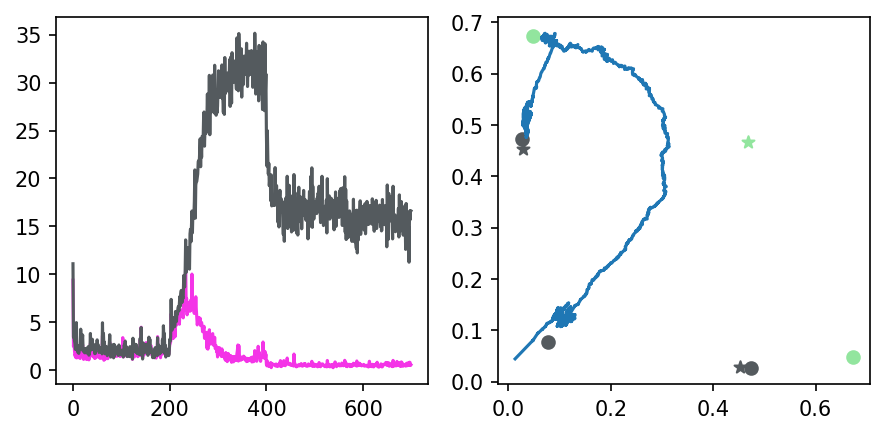

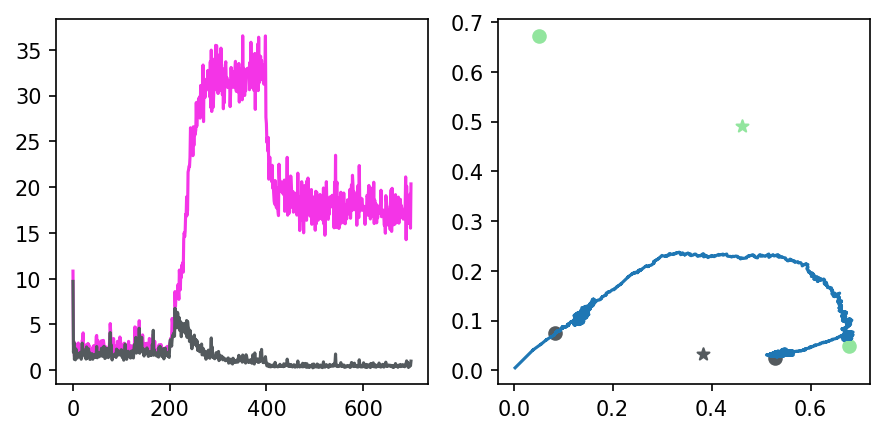

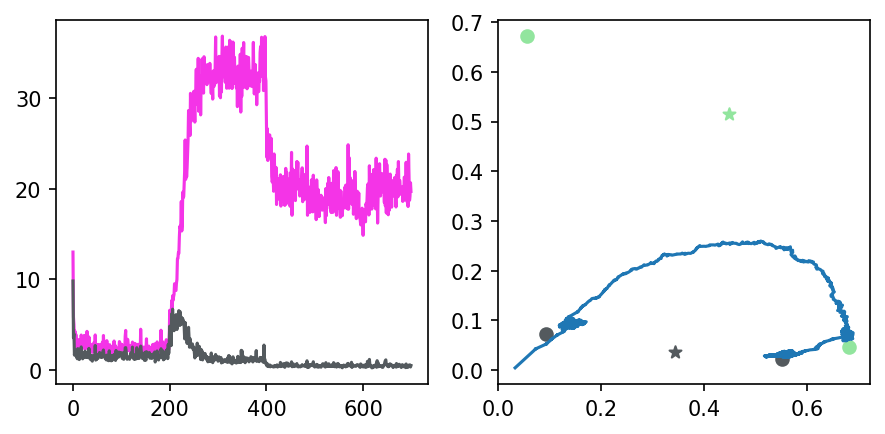

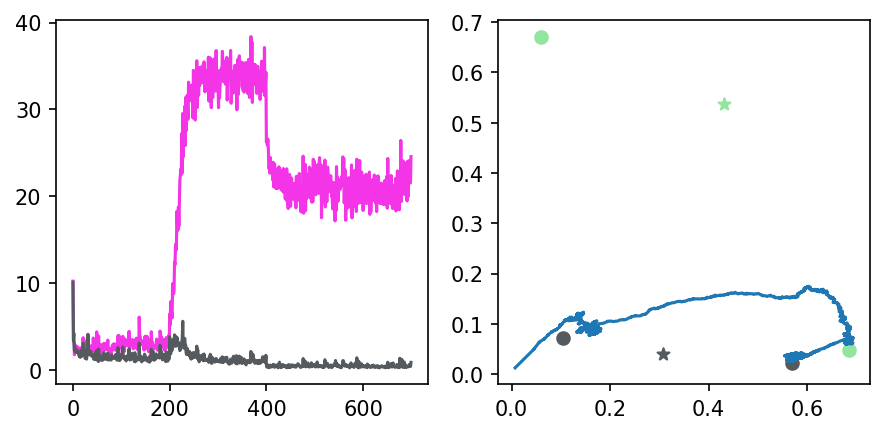

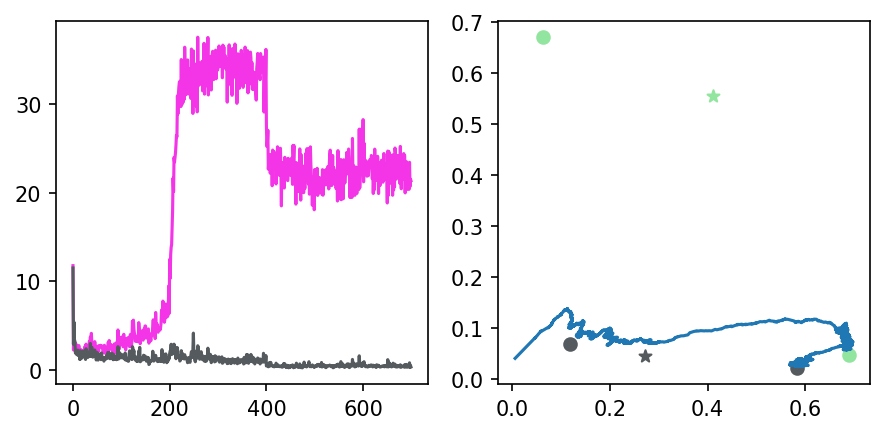

In [180]:
D2_array = np.linspace(0,50,5)
for i, D2 in enumerate(D2_array):
    sim = fourpop(GRIK4=0., D2 = np.array([D2,0]))
    plot_fixed_points(sim)

# Increasing GRIK4 stimulation of PV

MD_GRIK4 stimulates global PV inhibition.

/Users/hc793/miniconda3/envs/spine-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


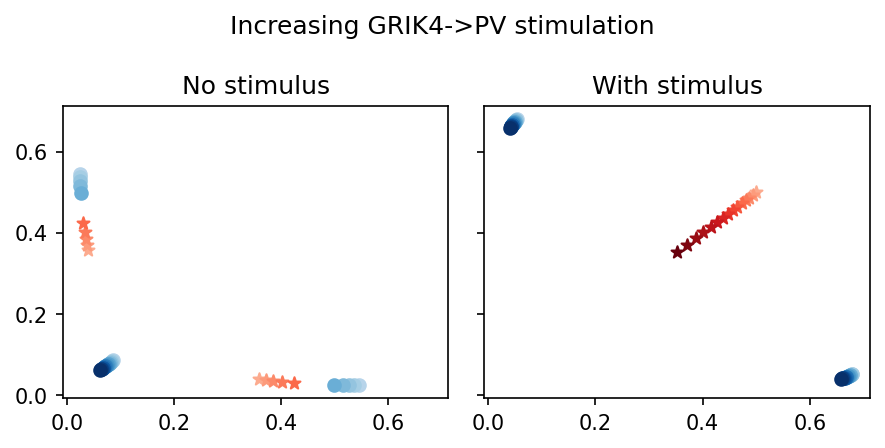

In [178]:
# What does this do to attractors?

GRIK4_array = np.linspace(0, 10, 15)

cmap = [matplotlib.cm.get_cmap('Blues')(i) for i in np.linspace(0.3,1,15)]
cmap_r = [matplotlib.cm.get_cmap('Reds')(i) for i in np.linspace(0.3,1,15)]

fig, axs = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True, dpi=150)
axs[0].set_title('No stimulus')
axs[1].set_title('With stimulus')
for i, GRIK4 in enumerate(GRIK4_array[:]):
    sim = fourpop(GRIK4=GRIK4, D2=0, custom_args={'JSOM':0})

    fp_u = sim.get_fixed_points(ifstim=False)
    fp_s = sim.get_fixed_points(ifstim=True)

    for j, point in enumerate(fp_u['points']):
        if fp_u['stable'][j] == 1:
            axs[0].scatter(fp_u['points'][j,0], fp_u['points'][j,1],c=[[cmap[i]]])
        else:
            axs[0].scatter(fp_u['points'][j,0], fp_u['points'][j,1], marker = '*',c=[[cmap_r[i]]])
    for j, point in enumerate(fp_s['points']):
        if fp_s['stable'][j] == 1:
            axs[1].scatter(fp_s['points'][j,0], fp_s['points'][j,1],c=[[cmap[i]]])
        else:
            axs[1].scatter(fp_s['points'][j,0], fp_s['points'][j,1], marker = '*',c=[[cmap_r[i]]])

fig.suptitle("Increasing GRIK4->PV stimulation")
fig.tight_layout()

/Users/hc793/miniconda3/envs/spine-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/hc793/miniconda3/envs/spine-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


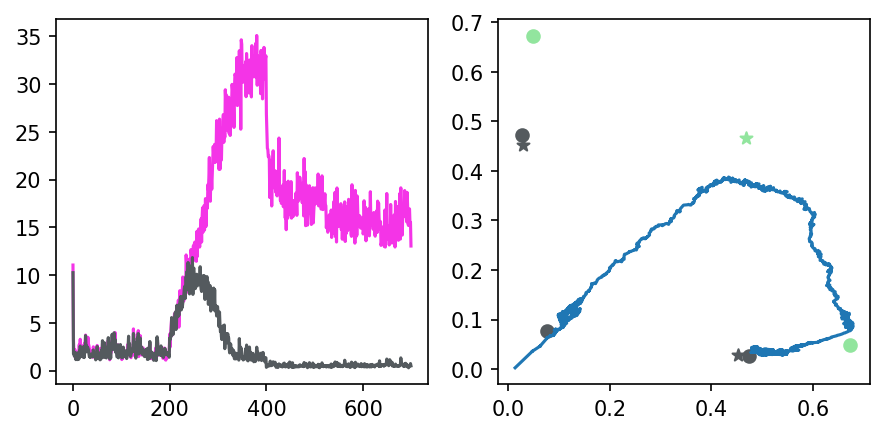

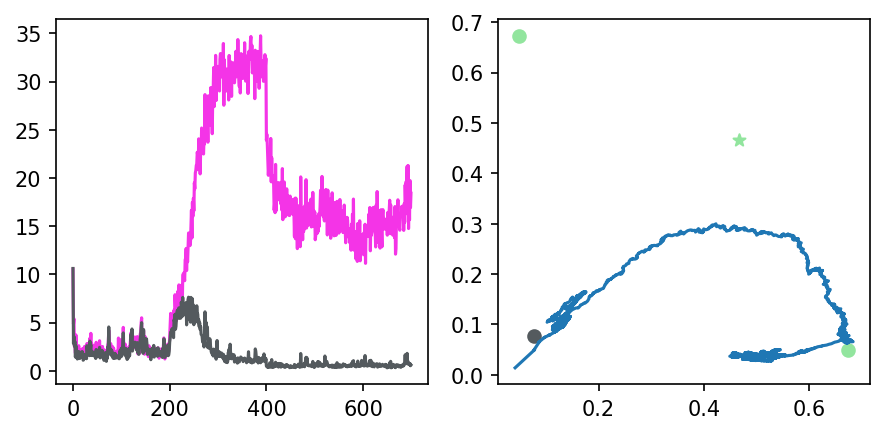

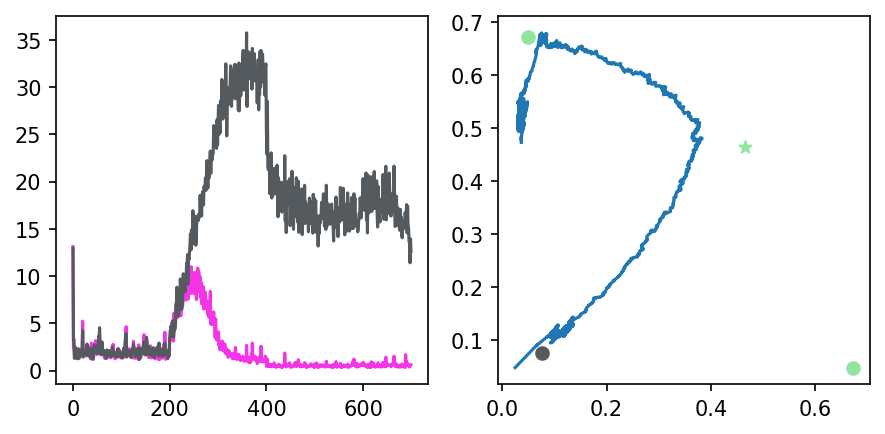

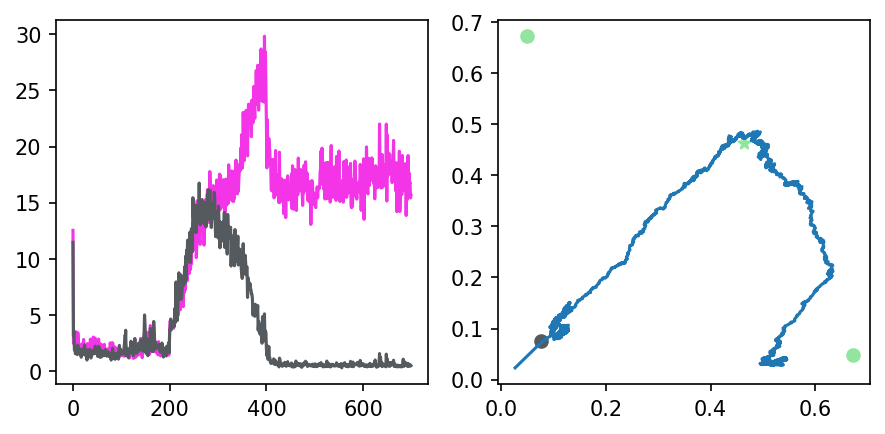

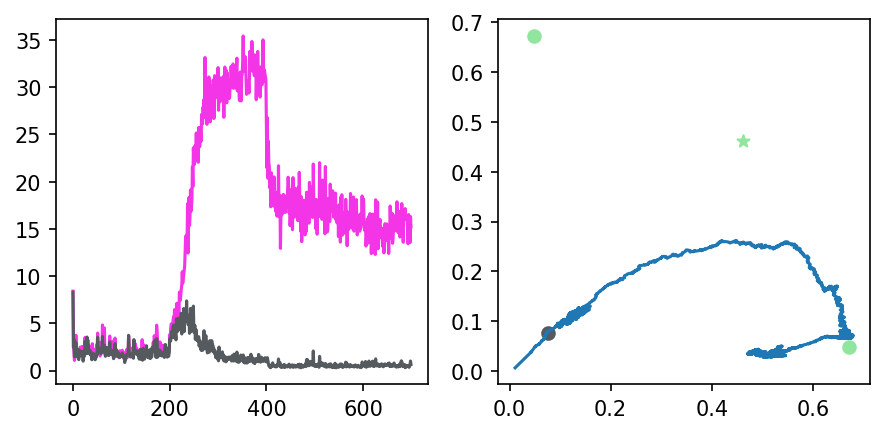

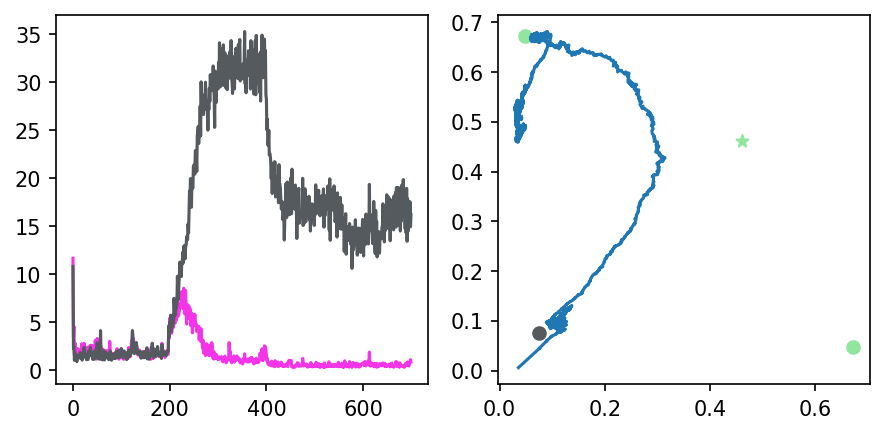

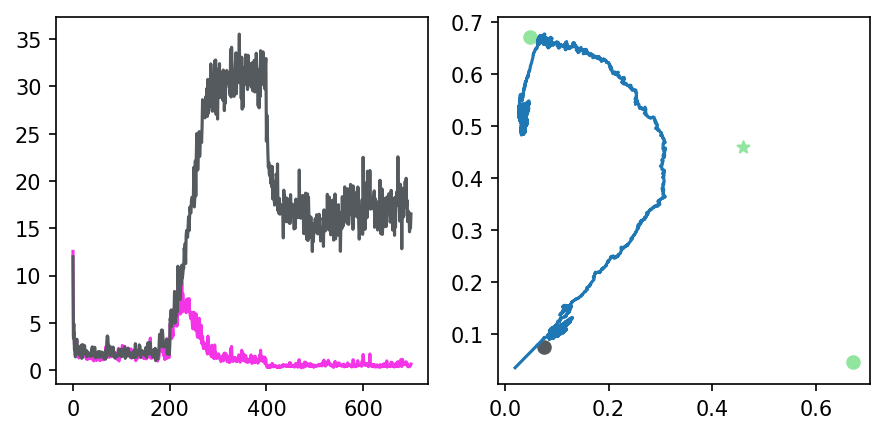

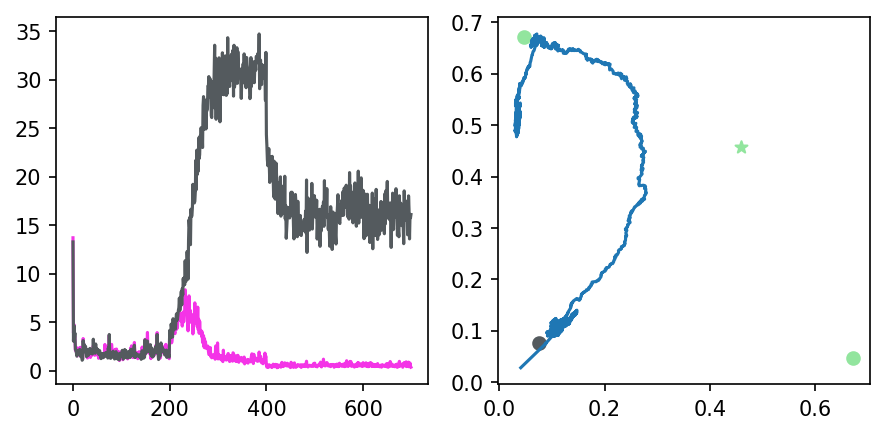

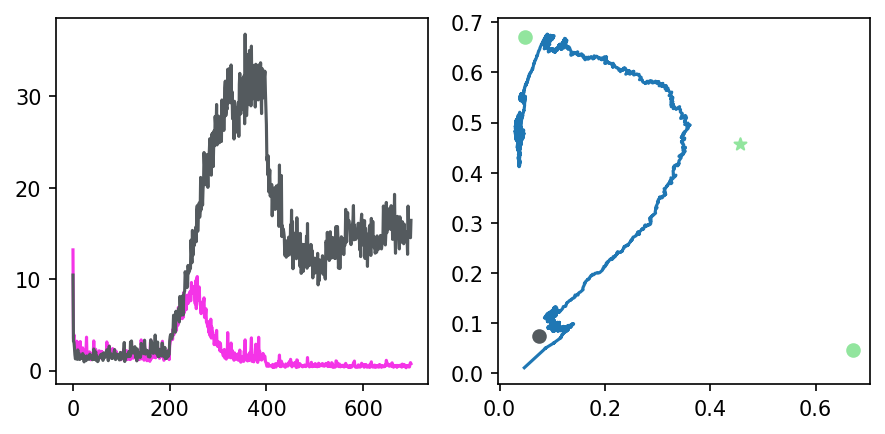

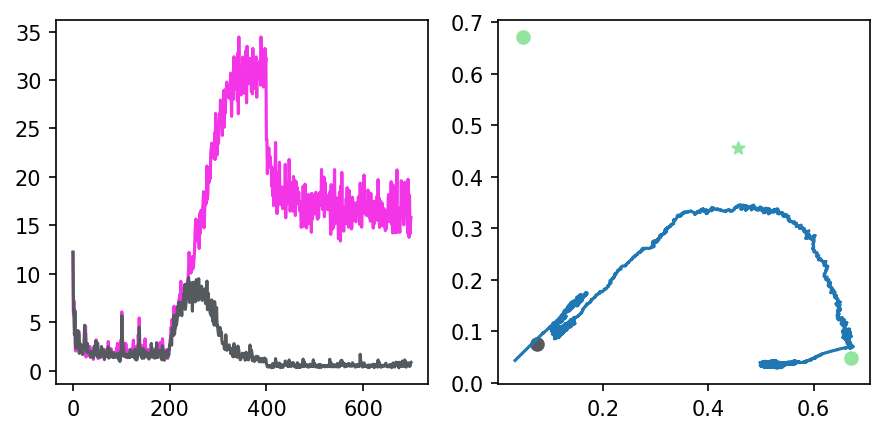

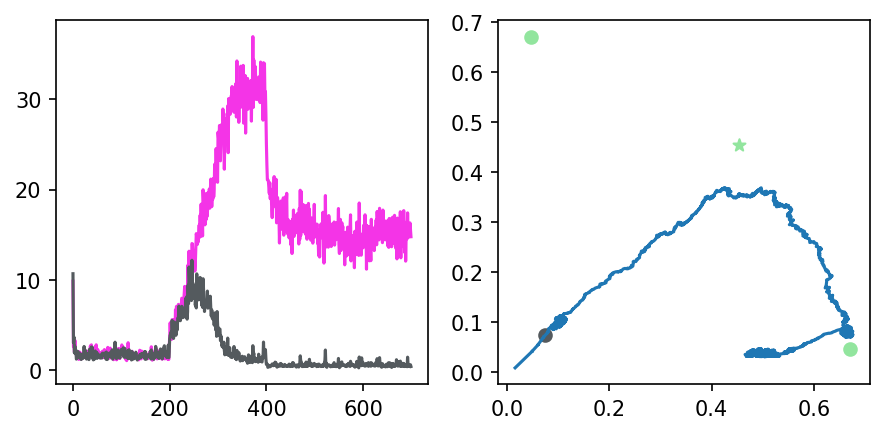

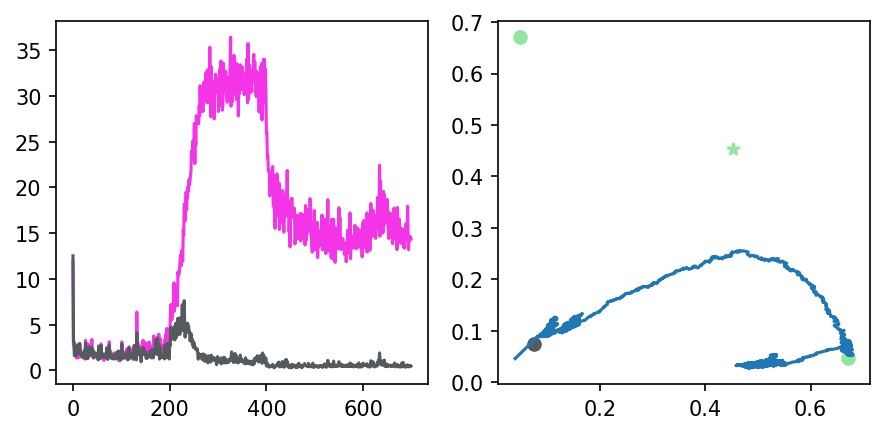

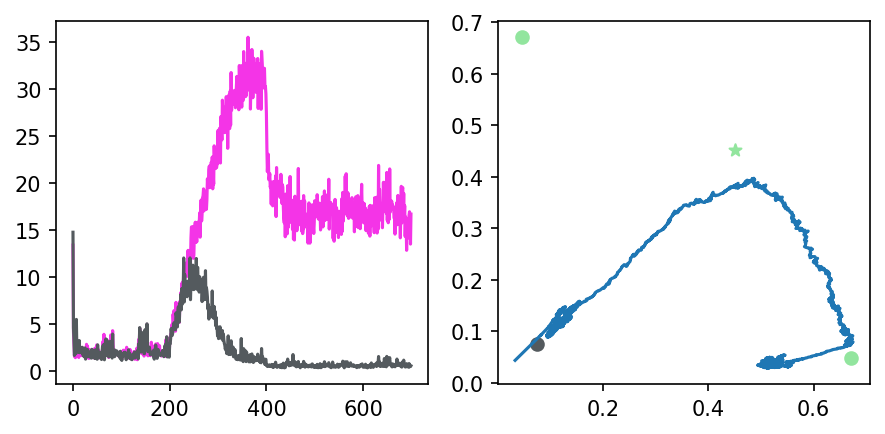

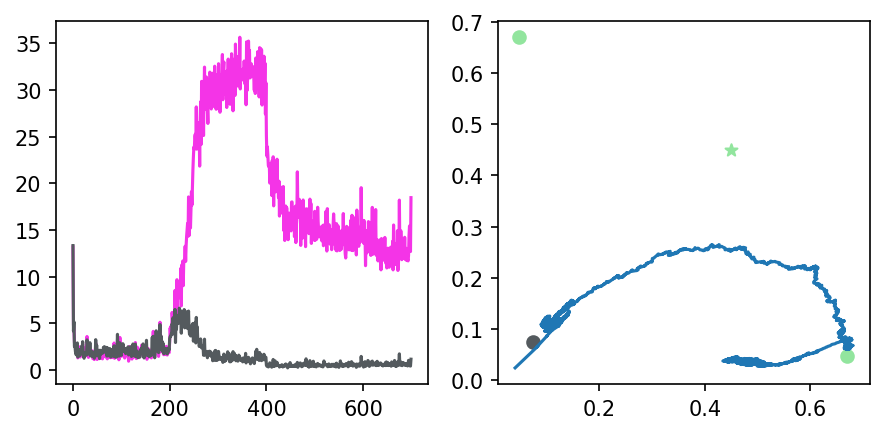

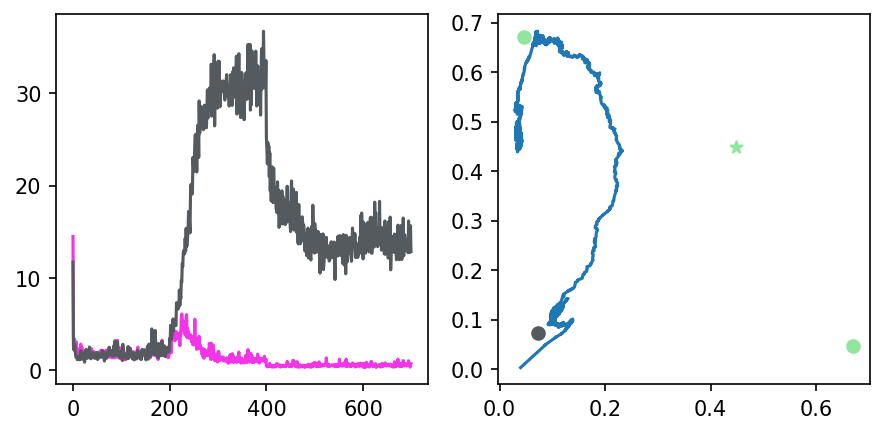

In [174]:
# what does increasing GRIK4 do?

GRIK4_array = np.linspace(0, 1.5, 15)
for i, GRIK4 in enumerate(GRIK4_array[:]):
    sim = fourpop(GRIK4=GRIK4, D2=0)
    plot_fixed_points(sim)
    

### HYP: The unstable fixed point when stimulus is presented is a lot closer to the initial fixed point when GRIK4-PV inhibiton is high. BUT the stable decision attractors disappear. If the inhibition is timed such that it only occurs with the stimulus, then it could potentially help the decision making structure when there is low signal.

In [39]:
# Scan for other fixed points to look at other cases
def fourD_fixedpoint_scan(see_arr,sei_arr,sie_arr,sii_arr):
    
    one_pts = see_arr.shape[0]
    two_pts = sei_arr.shape[0]
    thr_pts = sie_arr.shape[0]
    fou_pts = sii_arr.shape[0]
    
    ustim = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='bool')
    stim  = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='bool')
    
    s_pts  = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    s_stab = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    s_dS   = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    
    u_pts  = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    u_stab = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    u_dS   = np.empty([one_pts,two_pts,thr_pts,fou_pts],dtype='object')
    
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for i in range(one_pts):
            for j in range(two_pts):
                for k in range(thr_pts):
                    for l in range(fou_pts):
                        model = fourpop(0, 0, custom_args={'See':see_arr[i], 'Sei':sei_arr[j], 'Sie':sie_arr[k], 'Sii':sii_arr[l]})
                        stim_pts  = model.get_fixed_points(ifstim=True) 
                        ustim_pts = model.get_fixed_points(ifstim=False)
                        ustim[i,j,k,l] = np.all(ustim_pts['stable'] == np.array([1,0,1,0,1]))
                        stim[i,j,k,l]  = np.all(stim_pts['stable'] == np.array([1,0,1]))
                        
                        s_pts[i,j,k,l]  = stim_pts['points']
                        s_stab[i,j,k,l] = stim_pts['stable']
                        s_dS[i,j,k,l]   = stim_pts['dS']
                        
                        u_pts[i,j,k,l]  = ustim_pts['points']
                        u_stab[i,j,k,l] = ustim_pts['stable']
                        u_dS[i,j,k,l]   = ustim_pts['dS']
                        
                        #print(np.array([see_arr[i],sei_arr[j],sie_arr[k],sii_arr[l]]))
    gdd_points = {'is_good': ustim&stim,
                  's_pts': s_pts,
                  's_stab': s_stab,
                  's_dS': s_dS,
                  'u_pts': u_pts,
                  'u_stab': u_stab,
                  'u_dS': u_dS,
                  }
    
    return gdd_points

see_array = np.array([0.32])
sei_array = np.array([0.25])
sie_array = np.arange(-1., 1., 0.1)
sii_array = np.arange(-1., 1., 0.1)
gdd_points = fourD_fixedpoint_scan(see_array, sei_array, sie_array, sii_array)

In [45]:
np.array(see_array, sei_array, sie_array, sii_array)

TypeError: array() takes from 1 to 2 positional arguments but 4 were given

In [58]:
gdd_pts_idx = np.argwhere(gdd_points['is_good'])
gdd_pts_idx.T

for i in range(len(gdd_pts_idx.T[3])):
    print(gdd_points['u_stab'][0,0,gdd_pts_idx.T[2][i], gdd_pts_idx.T[3][i]])
    print('Sie = {}, Sii = {}'.format(sie_array[i],sii_array[i]))


[1. 0. 1. 0. 1.]
Sie = -1.0, Sii = -1.0
[1. 0. 1. 0. 1.]
Sie = -0.9, Sii = -0.9
[1. 0. 1. 0. 1.]
Sie = -0.8, Sii = -0.8
[1. 0. 1. 0. 1.]
Sie = -0.7000000000000001, Sii = -0.7000000000000001
[1. 0. 1. 0. 1.]
Sie = -0.6000000000000001, Sii = -0.6000000000000001
[1. 0. 1. 0. 1.]
Sie = -0.5000000000000001, Sii = -0.5000000000000001
[1. 0. 1. 0. 1.]
Sie = -0.40000000000000013, Sii = -0.40000000000000013
[1. 0. 1. 0. 1.]
Sie = -0.30000000000000016, Sii = -0.30000000000000016
[1. 0. 1. 0. 1.]
Sie = -0.20000000000000018, Sii = -0.20000000000000018
[1. 0. 1. 0. 1.]
Sie = -0.1000000000000002, Sii = -0.1000000000000002
[1. 0. 1. 0. 1.]
Sie = -2.220446049250313e-16, Sii = -2.220446049250313e-16
[1. 0. 1. 0. 1.]
Sie = 0.09999999999999964, Sii = 0.09999999999999964
[1. 0. 1. 0. 1.]
Sie = 0.19999999999999973, Sii = 0.19999999999999973
[1. 0. 1. 0. 1.]
Sie = 0.2999999999999998, Sii = 0.2999999999999998
[1. 0. 1. 0. 1.]
Sie = 0.3999999999999997, Sii = 0.3999999999999997
[1. 0. 1. 0. 1.]
Sie = 0.4999999

IndexError: index 20 is out of bounds for axis 0 with size 20